# Description

In this conditional GAN:

1. The encoder will take a 110-element vector (a 100-element noise vector concatenated with a one-hot 10-depth vector indicating a digit class) and output a one-dimensional vector with a size equal to the number of phosphenes in the grid to be tested.

2. The decoder will take a 3-dimensional matrix (a rendered 2D image with a replicated one-hot 10-depth vector indicating a digit class, concatenated on the last axis) and output a binary class indicating whether it believes the digit is fake or not. 

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time
import glob
import PIL
import pickle
from datetime import datetime
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import * 
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy.ndimage import gaussian_filter
from IPython import display

In [2]:
from phosphenes import *

Using TensorFlow backend.


#  Initialising a Grid


These parameters set the grid for testing.

In [3]:
gridType= PolarGrid
gridParam1 = 8
gridParam2 = 8
gridVectorLength = gridParam1 * gridParam2
renderSize1 = 48
renderSize2 = 48

We then initialise the grid.

In [4]:
grid = gridType(gridParam1, gridParam2, renderSize1, renderSize2)

Here is a plot depicting the relative locations and sizes of phosphenes on the grid.

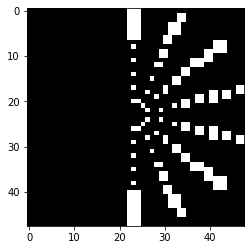

In [5]:
plt.imshow(grid.show_locations(), cmap='gray', vmin=0, vmax=1)

And here is a plot depicting the grid with all the phosphenes on at a brightness of 1 (the maximum brightness expected to be input into the renderer).

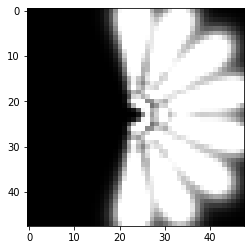

In [6]:
plt.imshow(grid.render(np.array([1 for i in range(gridVectorLength)])), cmap='gray', vmin=-1, vmax=1)

To visualise what the directly processed images look like, we first make a convenience function for generating digit images below.

In [7]:
def digit_to_image(digit : int, xpos : float, ypos : float):
    
    # Create a figure
    fig = plt.figure(figsize=(1,1))
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    
    # Remove axes and labels
    fig.patch.set_facecolor('black')
    plt.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    # Tighten 
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

    # Plot text
    plt.text(xpos, ypos, str(int(digit)),
             size=48,
             color='white',
             clip_box=ax.clipbox,
             clip_on=True,
             horizontalalignment = 'center',
             verticalalignment = 'center',
             linespacing = 0,
             transform=ax.transAxes)
    
    # Draw canvas
    canvas.draw()
    
    # Convert to numpy buffer
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    image = (image - 127.5) / 127.5
    
    # Close figure
    plt.close(fig)
    
    # Resize
    resized = cv2.resize(image, dsize=(renderSize1, renderSize2)).astype(np.float32)
    
    return resized

This function returns 2D images with values in the range [-1, 1].

Here's the original digits (deviated to the right to accommodate the fact that the output renders will only show in the right hemisphere).

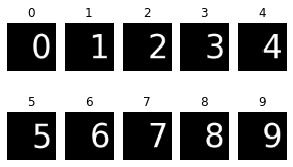

In [8]:
# Create the figure
fig = plt.figure(figsize=(5,3))

# Loop through the digits
for i in range(10):
    plt.subplot(2, 5, i+1)
    stimulus = Stimulus(digit_to_image(i, 0.7, 0.45), grid)
    plt.imshow((digit_to_image(i, 0.7, 0.45) + 1) / 2)
    plt.title(i)
    plt.axis('off')

And here they are when processed with the direct renderer for this grid.

Text(0.5, 0.98, 'Comparison (Direct, Brightness-Based)')

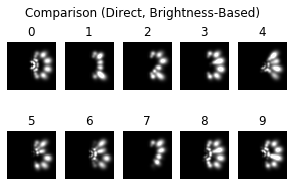

In [10]:
# COMPARISON
fig = plt.figure(figsize=(5,3))

for i in range(10):
    plt.subplot(2, 5, i+1)
    stimulus = Stimulus(digit_to_image(i, 0.7, 0.45), grid)
    plt.imshow(grid.render(stimulus.vector), cmap='gray', vmin=-1, vmax=1)
    plt.title(i)
    plt.axis('off')

plt.suptitle(f"Comparison (Direct, Brightness-Based)")

We also define a wrapper around `grid.render_tensor`.

# Preprocessing the Real Data

To train the decoder, we will have it distinguish between "real" digit images, and "fake" (i.e. the encoded) digit images.

The real digit images we will use are the MNIST digits. We will have to translate and rescale them to accommodate the grids we are using for the phosphenes. 

First, we load the digit data.

In [11]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

Here's the first image.

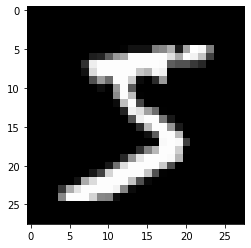

In [12]:
plt.imshow(train_images[0], cmap='gray')

Next, we determine their shape (the first dimension indicates how much data we have). 

In [13]:
num_real, original_y, original_x = train_images.shape

Below is a convenience function to process these images so that:
    
1. Their values are scaled between -1 and 1 (as opposed to 0 to 255 as they are now)
2. They are translated towards the right to accommodate the half-grid of phosphenes
3. They are scaled up in size to match the dimensions of the encoder renders

In [14]:
def process_images(images):
    
    # Upscale only to 80% of the render, to leave some padding around the digit
    up_x, up_y = int(renderSize1 * (3/4)), int(renderSize2 * (3/4))
    pad_y = (renderSize1 - up_y) // 2
    pad_x = (renderSize2 - up_x) // 2
    pad_widths = ((pad_y, pad_y), (pad_x, pad_x))

    processed = np.array([
        np.roll(
            
            # Pad and resize up to the render dimensions
            np.pad(
                cv2.resize(
                    image, 
                    dsize=(up_y, up_x)
                ), 
                pad_widths,
                'constant',
                constant_values=0
            ),
            
            # Shift along the X-axis to the right
            shift=(renderSize2 // 5),
            axis=1,
            
        )
        for image in train_images
    ])
    
    # Scale the values from 0-255 to -1-1
    processed = (processed - 127.5) / 127.5
    
    return processed

We then process both the training images and the test images.

In [15]:
train_images = process_images(train_images)

These aren't perfectly aligned, but it will do. (The MNIST digits are not bounding boxed, so there are some heuristic compromises in the code above). 

Here's an example of some of the digits.

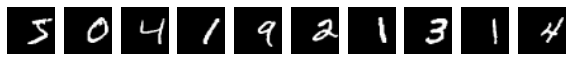

In [16]:
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].imshow(train_images[i], cmap='gray')
    ax[i].axis('off')

# Loading the Hole-Filler

In [17]:
filler_path = "./data/training-hole-filling/training-encoders/2019-07-18_13-57_encoder_48_48.h5"

In [18]:
filler = tf.keras.models.load_model(filler_path)

W0722 11:42:11.334687 13696 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [19]:
test_stimuli = [Stimulus(digit_to_image(i, 0.7, 0.45), grid) for i in range(10)]
test_renders = [grid.render(stimulus.vector) for stimulus in test_stimuli]
test_digits = tf.cast(np.array(test_renders), tf.float32)

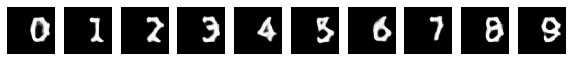

In [20]:
test_filled = filler(test_digits)

fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].imshow(test_filled[i], cmap='gray')
    ax[i].axis('off')

# Creating an Encoder

In [21]:
SEED_SIZE = 32

In [22]:
def make_encoder():

    # Input noise
    in_noise        = Input(shape=(SEED_SIZE,))
    
    # Layers for noise
    l_noise         = Dense(gridVectorLength // 4)(in_noise)
    l_noise         = BatchNormalization()(l_noise)
    l_noise         = LeakyReLU()(l_noise)
    
    # Input labels
    in_labels       = Input(shape=(1,))
    
    # Layers for labels
    l_labels        = Embedding(10, gridVectorLength // 4)(in_labels)
    l_labels        = Flatten()(l_labels)
    l_labels        = BatchNormalization()(l_labels)
    l_labels        = LeakyReLU()(l_labels)
    #l_labels        = Dense(gridVectorLength // 4)(l_labels)
    
    # Concatenate
    concat          = Concatenate()([l_noise, l_labels])
    concat          = Flatten()(concat)
    concat          = Dense(gridVectorLength // 2)(concat)
    concat          = LeakyReLU()(concat)
    #concat          = Concatenate()([concat, l_labels])
    #concat          = Dense(gridVectorLength // 2)(concat)
    #concat          = LeakyReLU()(concat)
    #concat          = Concatenate()([concat, l_labels])
    concat          = Dense(gridVectorLength, activation=tf.nn.sigmoid)(concat)
    
    # Model
    model           = Model([in_noise, in_labels], concat)
    
    return model

In [23]:
encoder = make_encoder()

Below is a convenience function that will take a tensor of digit labels and convert it into a noise vector concatenated with a one-hot encoded class. 

In [24]:
@tf.function
def make_inputs(labels):
    
    batch_size = len(labels)
    
    noise = tf.random.uniform((batch_size, SEED_SIZE))
    one_hot = tf.one_hot(labels, depth=10, dtype=tf.float32)
    
    return (noise, one_hot)

In [25]:
# @tf.function
# def make_inputs(labels):
    
#     batch_size = len(labels)
    
#     #noise = tf.random.uniform((batch_size, SEED_SIZE))
#     one_hot = tf.one_hot(labels, depth=10, dtype=tf.float32)
    
#     return one_hot

Here's an example of the encoder without any training.

In [26]:
test_labels = tf.convert_to_tensor(np.array([random.randint(0, 9) for i in range(100)]))

In [27]:
test_seeds, test_one_hot = make_inputs(test_labels)

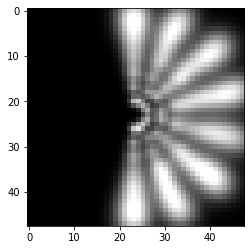

In [28]:
plt.imshow(
    grid.render_tensor(encoder((test_seeds, test_labels))[0].numpy()),
    cmap='gray',
    vmin=-1,
    vmax=1
)

Testing the filler (though this is garbage, so it should look like garbage):

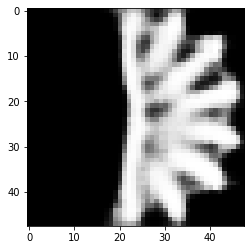

In [29]:
plt.imshow(filler(np.array([grid.render_tensor(encoder((test_seeds, test_labels))[0])]))[0], cmap='gray')

Looks like garbage to me!

We'll set the loss of the encoder to a binary cross entropy between the decoder's judgement of the encoded images, and a vector full of ones. The encoder should be aiming to get the decoder to judge it's outputs as 1s.

In [30]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [31]:
categorical_cross_entropy = tf.keras.losses.CategoricalCrossentropy()

In [32]:
def encoder_loss(real_labels, decoded_one_hot):
    
    real_one_hot = tf.one_hot(real_labels, depth=11)
    label_loss = categorical_cross_entropy(real_one_hot, decoded_one_hot)
    
    return label_loss

And we'll set the optimiser to `Adam`.

In [33]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Creating a Decoder

In [34]:
def make_decoder():
    
    # Image input
    in_images     = Input(shape=(renderSize1, renderSize2))
    l_images      = Reshape((renderSize1, renderSize2, 1))(in_images)
    
    # Convolution
    concat        = Conv2D(64, (8,8), padding='same', strides=(2,2))(l_images)
    concat        = LeakyReLU()(concat)
    concat        = Dropout(0.25)(concat)
    
    label_out     = Conv2D(128, (4,4), padding='same', strides=(2,2))(concat)
    label_out     = LeakyReLU()(label_out)
    label_out     = Dropout(0.25)(label_out)
    label_out     = Flatten()(label_out)
    label_out     = Dense(11, activation=tf.nn.softmax)(label_out)
    
    # Model 
    model         = Model(inputs=[in_images], outputs=label_out)
    
    return model    

In [35]:
decoder = make_decoder()

Here's an example:

In [36]:
test_images = tf.map_fn(lambda x: grid.render_tensor(x.numpy()), encoder((test_seeds, test_labels)))

In [37]:
test_one_hot = tf.one_hot(test_labels, depth=10, dtype=tf.float32)

In [38]:
decoder([test_images[:5]])

<tf.Tensor: id=16556, shape=(5, 11), dtype=float32, numpy=
array([[0.07752259, 0.09957568, 0.0843158 , 0.08867568, 0.09535678,
        0.08895545, 0.08221749, 0.10176688, 0.08175378, 0.10392641,
        0.09593344],
       [0.07751138, 0.09938931, 0.08433544, 0.08862742, 0.09508907,
        0.0889516 , 0.08229367, 0.10220072, 0.08173849, 0.10384165,
        0.09602125],
       [0.07716305, 0.09970189, 0.08468018, 0.08836255, 0.09527617,
        0.08890505, 0.08241973, 0.10150381, 0.0815197 , 0.1042162 ,
        0.0962517 ],
       [0.07710514, 0.09957884, 0.08431792, 0.0887955 , 0.09522435,
        0.08916426, 0.0822796 , 0.10195173, 0.08196777, 0.10378636,
        0.09582847],
       [0.07740884, 0.09947246, 0.08442914, 0.08875924, 0.09514462,
        0.08905574, 0.08228696, 0.10208205, 0.08167232, 0.10385914,
        0.0958294 ]], dtype=float32)>

The decoder loss is also a binary cross entropy. It should try to classify all the real images as real (i.e. 1s) and all the fake images as fake (i.e. 0s). 

In [39]:
def decoder_loss(real_labels, decoded_real_one_hot, decoded_fake_one_hot):
    
    shape = real_labels.shape
        
    real_one_hot = tf.one_hot(real_labels, depth=11)
    real_loss = categorical_cross_entropy(real_one_hot, decoded_real_one_hot)
    
    all_fake_one_hot = tf.one_hot(tf.fill(shape, 10), depth=11)
    fake_loss = categorical_cross_entropy(all_fake_one_hot, decoded_fake_one_hot)
    
    loss = real_loss + fake_loss
    
    return loss

We'll use an Adam optimizer for the decoder too.

In [40]:
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Preparing for Data Storage

For convenience, we define the filepaths for datastorage below.

We first put the datetime and grid parameters as part of the filepath.

In [41]:
save_dir = "./data/training-intermediate-data/"
base     = "{dir}/{time}_{type}_{gridType}_{gridParam1}-{gridParam2}_{gridSize1}-{gridSize2}.{ext}"
now      = datetime.now().strftime('%Y-%m-%d_%H-%M')

We define a common format for the base string.

In [42]:
common_format = {
    'time': now,
    'gridType': gridType.__name__,
    'gridParam1': gridParam1,
    'gridParam2': gridParam2,
    'gridSize1': renderSize1,
    'gridSize2': renderSize2,
}

Then we specify each path.

In [43]:
loss_filepath = save_dir + base.format(
    dir="training-losses",
    type='loss',
    ext='log',
    **common_format
)

gif_filepath = save_dir + base.format(
    dir="training-gifs",
    type='evolution',
    ext='gif',
    **common_format
)

grid_filepath = save_dir + base.format(
    dir='training-grids',
    type='grid',
    ext='pkl',
    **common_format
)

encoder_filepath = save_dir + base.format(
    dir='training-encoders',
    type='encoder',
    ext='h5',
    **common_format
)

# Training

Now that the encoder and decoder are prepared, we can begin to start training. 

We first define a function that will be run each training step.

In [44]:
@tf.function
def train_step(real_images, real_labels):
    
    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
        
        # Generate the encoder inputs with a random seed
        seeds, one_hot_labels = make_inputs(real_labels)
        # one_hot_labels = make_inputs(real_labels)
        
        # Produce encodings from the encoder inputs
        # encodings = encoder((one_hot_labels,), training=True)
        encodings = encoder((seeds, real_labels), training=True)

        # Render the encodings
        encoded_renders = tf.map_fn(grid.render_tensor, encodings)
        
        # Fill holes in encoded renders
        filled_renders = filler(encoded_renders)
        
        # Decode the rendered images
        # decoded_fake = decoder((encoded_renders, one_hot_labels))
        decoded_fake_one_hot = decoder((filled_renders,))
        
        # Decode the real images
        # decoded_real = decoder((real_dropout, one_hot_labels))
        decoded_real_one_hot = decoder((real_images,))

        # Calculate the losses for the encoder and decoder
        enc_loss = encoder_loss(real_labels, decoded_fake_one_hot)
        dec_loss = decoder_loss(real_labels, decoded_real_one_hot, decoded_fake_one_hot)

    # Output the losses to the log files
    tf.print(enc_loss, output_stream=enc_logfile)
    tf.print(dec_loss, output_stream=dec_logfile)
    
    # Calculate and apply the gradients to the encoder and decoder
    gradients_of_encoder = enc_tape.gradient(enc_loss, encoder.trainable_variables)
    gradients_of_decoder = dec_tape.gradient(dec_loss, decoder.trainable_variables)

    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
    decoder_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))

It will be useful to visualise the progression during training, so we will define a convenience function to visualise some sample digits.

First, we initiate some sample data - one for each digit.

In [45]:
display_labels = tf.convert_to_tensor(range(10))
display_seeds, display_one_hot = make_inputs(display_labels)

We then define the image directory to save progressive images to.

In [46]:
image_directory = "./data/training-intermediate-data/training-images/"

We then define a function to show the encoded renders for each digit.

In [47]:
def generate_and_save_images(encoder, epoch):
    
    encodings = encoder((display_seeds, display_labels), training=False)

    fig = plt.figure(figsize=(5,3))

    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(grid.render_tensor(encodings[i].numpy()),
                   cmap='gray',
                   vmin=-1,
                   vmax=1)
        plt.title(i)
        plt.axis('off')
        
    plt.suptitle(f"Epoch {epoch}")

    plt.savefig(image_directory + 'generated-epoch-{0:02d}.png'.format(epoch))
    plt.show()

Here's the example at the first epoch.

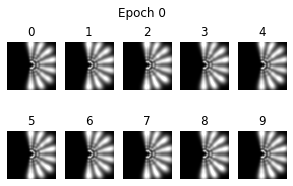

In [48]:
generate_and_save_images(encoder, 0)

We'll next define a batch size for training, and the total amount of data for training. We'll use all the MNIST training data for each epoch.

In [49]:
BATCH_SIZE = 250
EPOCH_SIZE = num_real // 2
NUM_BATCHES = EPOCH_SIZE // BATCH_SIZE

In [50]:
print(NUM_BATCHES)

120


We'll initialise the loss now, when the encoder has not been trained.

First defining the logpaths:

In [51]:
# Define the encoder and decoder log paths
enc_logpath = loss_filepath.replace("_loss_", "_enc_loss_cgan_")
dec_logpath = loss_filepath.replace("_loss_", "_dec_loss_cgan_")

# Format for tensorflow's print function
enc_logfile = "file://" + enc_logpath
dec_logfile = "file://" + dec_logpath

Then calculating an initial loss:

In [52]:
initial_labels = train_labels[:BATCH_SIZE]
initial_real = tf.cast(train_images[:BATCH_SIZE], tf.float32)

initial_seeds, initial_one_hot = make_inputs(initial_labels)
initial_encodings = encoder((initial_seeds, initial_labels))
initial_renders = tf.map_fn(lambda x: grid.render_tensor(x.numpy()), (initial_encodings))
initial_filled = filler(initial_renders)

initial_decoded_fake = decoder((initial_filled,))
initial_decoded_real = decoder((initial_real,))

Then clearing the logs and writing the first loss values.

In [53]:
with open(enc_logpath, 'w') as outfile:
    # encoder_loss_value = encoder_loss(initial_decoded_fake)
    encoder_loss_value = encoder_loss(initial_labels, initial_decoded_fake)
    outfile.write(str(encoder_loss_value.numpy()))
    outfile.write('\n')
    
with open(dec_logpath, 'w') as outfile:
    # decoder_loss_value = decoder_loss(initial_decoded_real, initial_decoded_fake)
    decoder_loss_value = decoder_loss(
        initial_labels, 
        initial_decoded_real,
        initial_decoded_fake
    )
    outfile.write(str(decoder_loss_value.numpy()))
    outfile.write('\n')

We then define a training loop.

In [54]:
def train(epochs):
    
    for epoch in range(epochs):
        start = time.time()

        for i in range(NUM_BATCHES):
            imin = i * BATCH_SIZE
            imax = (i+1) * BATCH_SIZE
            
            real_images_slice = tf.cast(train_images[imin:imax], tf.float32)
            real_labels_slice = tf.cast(train_labels[imin:imax], tf.int32)
            
            train_step(real_images_slice, real_labels_slice)

        # Generate and save progressive images
        display.clear_output(wait=True)
        generate_and_save_images(encoder, epoch + 1)

        print(f'Time for epoch {epoch+1} is {time.time()-start} sec.')

# Running the Training Loop

Finally, we can run the training loop.

We'll first define the number of epochs - we'll set an upper limit at 50, though we can halt it at any time.

In [55]:
EPOCHS = 50

Next, we run the training loop.

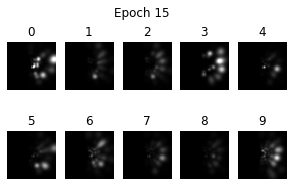

Time for epoch 15 is 699.9784553050995 sec.


KeyboardInterrupt: 

In [56]:
train(EPOCHS)

In [165]:
def brighten(values: np.ndarray) -> np.ndarray:
    return np.where(values > 0.12, 1.0, 0.0).astype(np.float32)

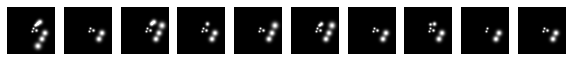

In [166]:
test_labels = np.array([4] * 10)

test_seeds, test_one_hot = make_inputs(test_labels)
# test_one_hot = make_inputs(test_labels)
test_encodings = encoder((test_seeds, test_labels))
# test_encodings = encoder((test_one_hot,))
#test_renders = tf.map_fn(lambda x: grid.render_tensor(x.numpy()), (test_encodings))
test_renders = tf.map_fn(lambda x: grid.render_tensor(brighten(x.numpy())), (test_encodings))


fix, axes = plt.subplots(1, 10, figsize=(10, 1))

for i, render in enumerate(test_renders):
    axes[i].imshow(render, cmap='gray', vmin=-1, vmax=1)
    axes[i].axis('off')

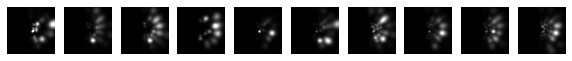

In [167]:
test_encodings = encoder((display_seeds, display_labels))
test_renders = tf.map_fn(lambda x: grid.render_tensor(x.numpy()), (test_encodings))

fix, axes = plt.subplots(1, 10, figsize=(10, 1))

for i, filled in enumerate(test_renders):
    axes[i].imshow(filled, cmap='gray')
    axes[i].axis('off')

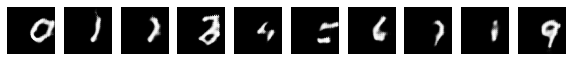

In [168]:
test_filled = filler(test_renders)

fix, axes = plt.subplots(1, 10, figsize=(10, 1))

for i, filled in enumerate(test_filled):
    axes[i].imshow(filled, cmap='gray')
    axes[i].axis('off')

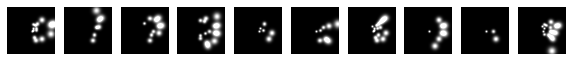

In [169]:
test_renders = tf.map_fn(lambda x: grid.render_tensor(brighten(x.numpy())), (test_encodings))

fix, axes = plt.subplots(1, 10, figsize=(10, 1))

for i, filled in enumerate(test_renders):
    axes[i].imshow(filled, cmap='gray')
    axes[i].axis('off')

In [149]:
test_real = tf.cast(train_images[:10], tf.float32)

class_real  = decoder(test_real)

print(tf.argmax(class_real, axis=1))

tf.Tensor([5 0 4 1 9 2 1 3 1 4], shape=(10,), dtype=int64)


In [150]:
class_fake = decoder(test_filled)

print(tf.argmax(class_fake, axis=1))

tf.Tensor([10 10 10 10 10 10 10 10 10  9], shape=(10,), dtype=int64)


# Viewing Results

Plotting the loss:

In [151]:
def plot_loss(logpath):
    
    enc_logpath = logpath.replace("_loss_", "_enc_loss_cgan_")
    dec_logpath = logpath.replace("_loss_", "_dec_loss_cgan_")
    
    with open(enc_logpath) as infile:
        enc_loss_raw = infile.readlines()
        
    with open(dec_logpath) as infile:
        dec_loss_raw = infile.readlines()

    enc_loss_data = np.array(list(map(float, enc_loss_raw)))
    dec_loss_data = np.array(list(map(float, dec_loss_raw)))

    plt.plot(range(enc_loss_data.shape[0]), enc_loss_data, color='teal', label='Loss for encoder training')
    plt.plot(range(dec_loss_data.shape[0]), dec_loss_data, color='tomato', label='Loss for decoder training')
    plt.ylabel("Categorical Cross Entropy Loss")
    plt.xlabel("Training Batch (each containing 500 images)")
    plt.title("Loss per Epoch")
    plt.legend()

    plot_file = logpath.replace("losses", "graphs").replace(".log", ".png")
    plt.savefig(plot_file)
    print("./03-psychophysics/" + plot_file)
    return plot_file

./03-psychophysics/./data/training-intermediate-data/training-graphs/2019-07-22_11-42_loss_PolarGrid_8-8_48-48.png


'./data/training-intermediate-data/training-graphs/2019-07-22_11-42_loss_PolarGrid_8-8_48-48.png'

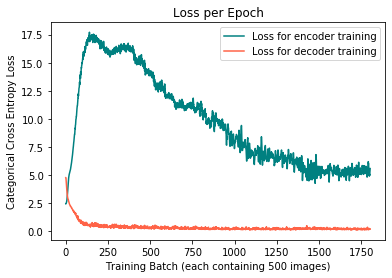

In [152]:
plot_loss(loss_filepath)

In [ ]:
generated_images = glob.glob(image_directory + ("*.png"))
images = [PIL.Image.open(image) for image in generated_images]

# save the first image 10 times
images[0].save(gif_filepath,
               save_all=True,
               append_images=[images[0]] * 10 + images + [images[-1]]*10,
               duration=100,
               loop=0)

In [ ]:
#with open(grid_filepath, 'wb') as outfile:
#    pickle.dump(grid, outfile)
#encoder.save(encoder_filepath)
# encoder = tf.keras.models.load_model(encoder_filepath)